## Using Spatial Statistics to Examine the Relationship between Tree Canopy and Transit Use in LA County Neighborhoods

### Maxwell Kilman

Expanding on my previous analysis of the relationship between tree canopy and transit use in two LA County neighborhoods––Westlake and Silverlake––I aim to better understand whether there is a statistically significant tendency for low tree canopy cover to cluster in neighborhoods with high transit use. In my [cleaned notebook](https://jupyter.idre.ucla.edu/user/mtk@g.ucla.edu/lab/tree/up221-max/Week07/Kilman_CleanNotebook1.ipynb), I identified descriptive statistics indicative of an indirect relationship between these two variables of interest. To further understand this potential relationship, I will conduct global spatial autocorrelation using Moran's I and conduct local spatial autocorrelation using Local Indicators of Spatial Association (LISAs). 

### Importing the Necessary Libraries

In [2]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# graphics
import matplotlib.pyplot as plt
import plotly.express as px

# code to hide warning messages 
import warnings
warnings.filterwarnings("ignore")

Having imported the necessary libraries for analysis and visualization, we can import the datasets we will work with.

### Importing Datasets

As noted in my [cleaned notebook](https://jupyter.idre.ucla.edu/user/mtk@g.ucla.edu/lab/tree/up221-max/Week07/Kilman_CleanNotebook1.ipynb), we rely on two datasets for this information: 
1. [Census Data (ACS 1-year survey data from 2022)](https://www.census.gov/programs-surveys/acs/)
2. [Heat Health Census Tracts data](https://gis-for-racialequity.hub.arcgis.com/datasets/7f05981247034b5da1887f14b7ed523b/explore)

The ACS 1-year survey data from 2022 includes critical demographic and socioeconomic data our group relies on in the preceding sections of our project (see Ali Kirste and Jazz Henry's Jupyter Notebooks). In this portion of our project, we use data on the total number of commuters and the count of public transportation users by census tract. Combined, these two columns allow us to add a percentage transit users column that scales the number of transit users in each census tract with the total number of commuters. This allows us to accurately compare transit use between tracts with differing populations.

By bringing in the Heat Health Census Tracts data, we can assess the percent tree canopy in each of these LA County census tracts. Using two geoJSON files that pair census tracts with the LAC geography and neighborhood names, we can narrow our analysis to our two neighborhoods of interest. 

1. [Census Tracts GeoJSON](up221-max/Week04/Data/Census_Tracts_20202.geojson)
2. [Nighborhood Geography GeoJSON](https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson)

In [3]:
# importing 2022 ACS datasets
ACS = pd.read_csv('Data/ACS_22C.csv')
# importing heat health census tracts 
CHS = gpd.read_file('Data/heat health census.csv')
# importing census tracts geojson
tracts = gpd.read_file('Data/Census_Tracts_20202.geojson')
# importing neighborhood geography 
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

### Data Cleaning

To prepare these two datasets for analysis, we will need to conduct some basic data-cleaning processes. In particular, we need to use the `dtype` command to convert `GEO_ID` to an `str` or `object` to maintain the leading zeros in each FIPS code. Next, we will want to subset the ACS dataframe and Census Health Tracts dataframe to include only the columns of interest. In the ACS dataframe these include, `GEO_ID`; the total counts of public transportation use excluding taxicab (column `B08301_010E`); the overall total of commuters for each census tract (`B08301_001E`). In addition to subsetting our dataframes, we will want to merge them with each other as well as with our two geoJSON files. To do so, we will employ both the `.merge()` command as well as the `.sjoin()` command. 

In [4]:
# converting GEO_ID to a string for 22
ACS = pd.read_csv(
    'Data/ACS_22C.csv',
    dtype=
    {
        'GEO_ID':str
    }
)

In [5]:
# subsetting the ACS dataframe  
columns_to_keep = ['GEO_ID',
                   'B08301_010E',
                   'B08301_001E'
                  ]
ACSb = ACS[columns_to_keep]


In [6]:
# adding percentage transit for 2022
ACSb['transit_pct'] = (ACSb['B08301_010E'] / ACSb['B08301_001E']) * 100


/tmp/ipykernel_70/1501812335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACSb['transit_pct'] = (ACSb['B08301_010E'] / ACSb['B08301_001E']) * 100


In [7]:
# changing column names ACS 22
ACSb.columns = ['GEOID',
'Total Transit Users (excluding taxicabs)',                 
'Total Commuters', 
'Percent Transit Users'
                  ]
# Reviewing column label changes 
ACSb.head()

GEOID  Total Transit Users (excluding taxicabs)  Total Commuters  \
0  06037101110                                        49             2043   
1  06037101122                                         9             2014   
2  06037101220                                        91             1665   
3  06037101221                                        47             1762   
4  06037101222                                        19             1105   

   Percent Transit Users  
0               2.398434  
1               0.446872  
2               5.465465  
3               2.667423  
4               1.719457

In [8]:
# indexing based on percent transit users and sorting by rank 
ACSb['Rank'] = ACSb['Percent Transit Users'].rank(ascending = 0) 
ACSb = ACSb.set_index('Rank') 
ACSb = ACSb.sort_index() 
# filtering for only values that are not NaN
ACSb = ACSb[ACSb['Percent Transit Users'].notnull()]

/tmp/ipykernel_70/1234187157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACSb['Rank'] = ACSb['Percent Transit Users'].rank(ascending = 0)


In [9]:
# CHS resolving issues with geoid column (FIPS)
CHS['GEOID'] = CHS['GEOID'].astype(str)

In [10]:
# CHS adding the leading zero back to the geoid/fips column
CHS['GEOID'] = CHS['GEOID'].str.zfill(11)

In [11]:
# CHS maintaining only LAC and deleting all other counties from df
counties_to_keep = ['Los Angeles County']

# Use boolean indexing to filter the DataFrame
CHSb = CHS[CHS['County'].isin(counties_to_keep)]

In [12]:
# subsetting tracts data and editing to create a FIPS column
tracts = tracts[['CT20','geometry']]
tracts['GEOID'] ='06' + '037' + tracts['CT20']
tracts.head()

CT20                                           geometry        GEOID
0  101110  POLYGON ((-118.28491 34.25948, -118.28492 34.2...  06037101110
1  101122  POLYGON ((-118.29015 34.27417, -118.29015 34.2...  06037101122
2  101220  POLYGON ((-118.28100 34.25592, -118.28198 34.2...  06037101220
3  101221  POLYGON ((-118.28735 34.25591, -118.28863 34.2...  06037101221
4  101222  POLYGON ((-118.28594 34.25405, -118.28594 34.2...  06037101222

In [13]:
# merging CHS and tracts on geoid
CHSbt =tracts.merge(CHSb,on="GEOID")

In [14]:
# merging CHS, tracts, and ACS 
CHSbta = CHSbt.merge(ACSb,on="GEOID")

In [15]:
# creating an appropriate geodataframe to join with neighborhoods
CHSbtac = gpd.GeoDataFrame(
   CHSbta,geometry = 'geometry_x', crs=4326)
# spatial join to merge full dataset and neighborhoods 
CHSA = gpd.sjoin(neighborhoods, CHSbtac)

To prepare the descriptive statistics we examine before conducting further statistical techniques, we produce the following function to calculate mean values for percent transit use and percent tree canopy in each neighborhood. 

In [16]:
# creating function for scatterplot for LAC and creating df with all summary stats
def neighborhood_scatter(name):
    # adding code to subset for the listed neighborhood
    neighborhood_data = CHSA[CHSA['name'] == name].copy()
        
    # defining the columns to look into 
    columns_to_analyze = [
        'Percent Transit Users',
        'MEAN_PCT_TreeCanopy',
    ]

    # must convert to numeric rather than str format of our gdf 
    for col in columns_to_analyze:
        neighborhood_data[col] = pd.to_numeric(neighborhood_data[col], errors='coerce')

    # calculating statistics for specified columns
    Mean_Percent_Transit_Users = neighborhood_data['Percent Transit Users'].mean()
    Mean_Percent_Tree_Canopy = neighborhood_data['MEAN_PCT_TreeCanopy'].mean()

    # creating dictionary for neighborhood statistics
    neighborhood_stats = {
        'Neighborhood': name,
        'Mean Percent Transit Users': Mean_Percent_Transit_Users,
        'Mean Percent Tree Canopy': Mean_Percent_Tree_Canopy
    }
    
    return neighborhood_stats

# creating list for storing output of neighborhood statistics
neighborhood_stats_list = []

# creating a loop and running function for each neighborhood
neighborhood_names = CHSA['name'].unique()
for name in neighborhood_names:
    stats = neighborhood_scatter(name)
    neighborhood_stats_list.append(stats)

# adding summary stats to the list into df 
summary_stats = pd.DataFrame(neighborhood_stats_list)

In [17]:
# changing column name to allow for merge on 
CHSc = CHSA.rename(columns={'name': 'Neighborhood'})
# merging on Neighborhood  
CHSd = CHSc.merge(summary_stats,on="Neighborhood")
# reordring column to place geometry column on right 
# moving the geometry column to right end for mapping purposes
non_geometry_columns = [col for col in CHSd.columns if col != CHSd.geometry.name]

# reordering to put geometry column on right
new_column_order = non_geometry_columns + [CHSd.geometry.name]

# creating new df with the reordered columns
CHSAbd = CHSd[new_column_order]
CHSAbd.sample()

OBJECTID_left Neighborhood  index_right    CT20        GEOID  \
237             97     Van Nuys          146  122000  06037122000   

    OBJECTID_right               NAME       State              County  \
237           9783  Census Tract 1220  California  Los Angeles County   

    Low_Summer_Mean_LST_F  ... B16004_calc_pctGE18LEAE_Z_SCORE SHAPE_Length  \
237           118.3194733  ...                     0.447036607  0.088768888   

      SHAPE_Area geometry_y Total Transit Users (excluding taxicabs)  \
237  0.000319202       None                                       45   

    Total Commuters Percent Transit Users Mean Percent Transit Users  \
237            2369              1.899536                   6.467381   

    Mean Percent Tree Canopy  \
237                  2.55586   

                                              geometry  
237  POLYGON ((-118.46751 34.22016, -118.46630 34.2...  

[1 rows x 58 columns]

Additionally, given that a more precise geography will yield better spatial correlation results, we will merge our dataset with their corresponding census block groups: [Census Reporter–ACS 2021 5 year](https://censusreporter.org/data/table/?table=B01003&geo_ids=16000US0644000,150|16000US0644000&primary_geo_id=16000US0644000)

In [18]:
# importing population block group data from census reporter
gdf_bg = gpd.read_file('Data/acs2021_5yr_B01003_15000US060371041082-Copy1.geojson')

# reprojecting to web mercator projection 
gdf_bg = gdf_bg.to_crs(epsg=3857)

In [19]:
# reprojecting gdf to web mercator projection as well 
CHSAbd = CHSA.to_crs(epsg=3857)

In [20]:
# reducing dataframe these are the columns being kept  
gdf_bg = gdf_bg[['geoid','B01003001','geometry']]

# deleting last row which is for the entire city of LA
gdf_bg.drop(gdf_bg.tail(1).index,inplace=True)

# renaming the columns
gdf_bg.columns = ['GEOID','TotalPop','geometry']

# altering GEOID/FIPS code -- to right of US 
gdf_bg['GEOID'] = gdf_bg['GEOID'].str.replace('15000US','')

# sorting by total pop -- in order to delete those with less than 100 ppl
gdf_bg.sort_values(by='TotalPop')

# deleting geographies with less than 100 ppl in population 
gdf_bg = gdf_bg[gdf_bg['TotalPop']>100]
gdf_bg

GEOID  TotalPop  \
0     060371011101    1630.0   
1     060371011102    1492.0   
2     060371011103     757.0   
3     060371011221    2608.0   
4     060371011222    1639.0   
...            ...       ...   
2669  060379800101     109.0   
2671  060379800151    1028.0   
2672  060379800171    1075.0   
2678  060379800241     200.0   
2681  060379800311    1160.0   

                                               geometry  
0     MULTIPOLYGON (((-13168130.287 4063777.973, -13...  
1     MULTIPOLYGON (((-13169350.794 4063591.834, -13...  
2     MULTIPOLYGON (((-13169185.150 4064208.314, -13...  
3     MULTIPOLYGON (((-13169467.902 4065613.937, -13...  
4     MULTIPOLYGON (((-13168066.056 4064987.278, -13...  
...                                                 ...  
2669  MULTIPOLYGON (((-13163713.575 4039600.478, -13...  
2671  MULTIPOLYGON (((-13170262.055 3997538.878, -13...  
2672  MULTIPOLYGON (((-13187896.844 4037650.325, -13...  
2678  MULTIPOLYGON (((-13193418.068 4053521.172, -13...  
2681  MULTIPOLYGON (((-13168099.229 3995788.284, -13...  

[2671 rows x 3 columns]

In [21]:
 CHSAbd = CHSAbd.rename(columns={'index_left': 'il'})
CHSAbd = CHSAbd.rename(columns={'index_right': 'ir'})
join = gpd.sjoin(gdf_bg, CHSAbd, how='left')
join.sample()

GEOID_left  TotalPop  \
1353  060372037201    2468.0   

                                               geometry  index_right  \
1353  MULTIPOLYGON (((-13158719.226 4035298.920, -13...            9   

      OBJECTID_left           name    ir    CT20  GEOID_right OBJECTID_right  \
1353             10  Boyle Heights  1340  530901  06037530901          11161   

      ... B17020_calc_pctPovE_Z_SCORE B18101_calc_pctDE_Z_SCORE  \
1353  ...                -0.053372585              -0.910090788   

     PCT_HH_Lives_Alone_Z_SCORE B16004_calc_pctGE18LEAE_Z_SCORE SHAPE_Length  \
1353               -1.084022365                     1.208685661  0.026701587   

     SHAPE_Area geometry_y Total Transit Users (excluding taxicabs)  \
1353   4.34E-05       None                                      128   

     Total Commuters Percent Transit Users  
1353            1974              6.484296  

[1 rows x 59 columns]

In [22]:

# reordring column to place geometry column on right 
# moving the geometry column to right end for mapping purposes
non_geometry_columns = [col for col in join.columns if col != join.geometry.name]

# reordering to put geometry column on right
new_column_order = non_geometry_columns + [join.geometry.name]

# creating new df with the reordered columns
CHSAbd = join[new_column_order]
CHSAbd.sample()

GEOID_left  TotalPop  index_right  OBJECTID_left         name   ir  \
2499  060372764004     697.0          104            105  Westchester  823   

        CT20  GEOID_right OBJECTID_right               NAME  ...  \
2499  276500  06037276500          10548  Census Tract 2765  ...   

     B18101_calc_pctDE_Z_SCORE PCT_HH_Lives_Alone_Z_SCORE  \
2499              -0.820887247                0.176576611   

     B16004_calc_pctGE18LEAE_Z_SCORE SHAPE_Length   SHAPE_Area geometry_y  \
2499                    -1.374827929  0.045683614  0.000116272       None   

     Total Transit Users (excluding taxicabs) Total Commuters  \
2499                                       25            2149   

     Percent Transit Users                                           geometry  
2499              1.163332  MULTIPOLYGON (((-13181743.325 4023413.343, -13...  

[1 rows x 59 columns]

### Overview of Descriptive Statistics

First, I employ `plotly` to produce a scatter plot with data from all neighborhoods in LA County examining the relationship between percent transit use and percent tree canopy cover.

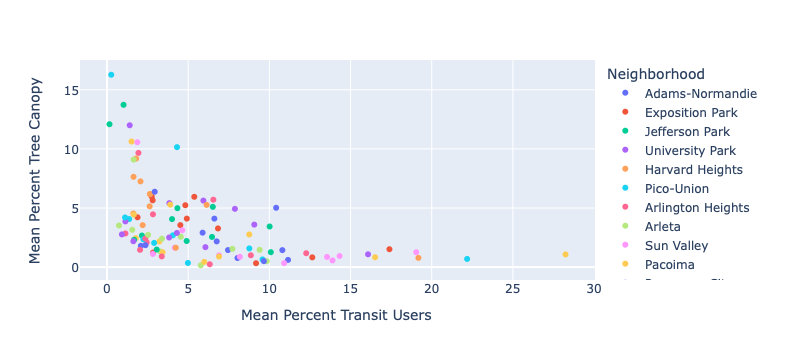

In [37]:
# creating scatterplot 
fig = px.scatter(summary_stats, x="Mean Percent Transit Users", y="Mean Percent Tree Canopy", color="Neighborhood")
fig.show()

As predicted, a scatterplot examining the relationship between the mean percent of tree canopy cover versus the mean percent of transit users by neighborhood is suggestive of an inverse relationship between these two variables. This offers us a broader idea of how the trend we observed between our subset of two neighborhoods (Westlake and Silverlake), appears to be reflected across all of LA County. This plot lends greater credence to our expectation of a trend whereby areas with the highest transit use disproportionately confront a lack of tree cover, and as our demographic and socioeconomic data analysis (conducted by Ali and Jazz) would suggest, these areas are predominantly low-income communities of color. To better understand the geography of this pattern, we can conduct global spatial autocorrelation using Moran's I and conduct local spatial autocorrelation using Local Indicators of Spatial Association (LISAs) to assess if there is a statistically significant tendency for low percent tree canopy cover and high percent transit use to cluster in certain communities.

## Spatial Statistics

### Global Spatial Autocorrelation – Percent Tree Canopy

Using global Moran's I statistic, we can quantify the degree to which similar geographies are clustered in regards to the percent tree canopy cover. As in the Week08 Lab, we use the KNN weight and row standardize the data. 


In [23]:
CHSAbd = CHSAbd.reset_index(drop=True)
# calculating spatial weight -- throughout whole city of LA -- expected avg pct tree canopy for a block group 
wq =  lps.weights.KNN.from_dataframe(CHSAbd,k=8) # pysal number of neighbors is 8 for each blockgroup 

# standardizing rows
wq.transform = 'r'

/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2619 disconnected components.
  warnings.warn(message)


Next, we use these spatial weights to calculate the corresponding spatial lag as well as the difference between the percent tree canopy cover and spatial lag. 

In [33]:
# creating a new column for spatial lag of pct tree canopy -- avg of all neighbors defined by weight (8) 
CHSAbd['MEAN_PCT_TreeCanopy'] = pd.to_numeric(CHSAbd['MEAN_PCT_TreeCanopy'], errors='coerce')
CHSAbd['Mean Percent Tree Canopy_lag'] = lps.weights.lag_spatial(wq, CHSAbd['MEAN_PCT_TreeCanopy'])

In [40]:
# reviewing alterations 
CHSAbd.sample(10)

GEOID_left  TotalPop  index_right  OBJECTID_left            name  \
11884  060371200102     973.0           71             72   Panorama City   
24861  060371340012    2705.0          111            112        Winnetka   
38055  060371917201    1733.0           25             26  East Hollywood   
2047   060371047042    1490.0           69             70         Pacoima   
54046  060372140004    1003.0           61             62    Mid-Wilshire   
57353  060372200002    1067.0          103            104      West Adams   
18816  060371271041    2107.0           96             97        Van Nuys   
27554  060371374013    2619.0          112            113  Woodland Hills   
39913  060371941022     978.0           49             50       Hollywood   
29191  060371412012    1417.0           83             84    Sherman Oaks   

        ir    CT20  GEOID_right OBJECTID_right                  NAME  ...  \
11884  117  119320  06037119320           9753  Census Tract 1193.20  ...   
24861  250  134201  06037134201           9896  Census Tract 1342.01  ...   
38055  384  191203  06037191203          10051  Census Tract 1912.03  ...   
2047    13  104105  06037104105           9637  Census Tract 1041.05  ...   
54046  572  216100  06037216100          10256     Census Tract 2161  ...   
57353  787  270200  06037270200          10506     Census Tract 2702  ...   
18816  226  128802  06037128802           9867  Census Tract 1288.02  ...   
27554  271  135201  06037135201           9920  Census Tract 1352.01  ...   
39913  394  191720  06037191720          10061  Census Tract 1917.20  ...   
29191  186  124700  06037124700           9823     Census Tract 1247  ...   

      PCT_HH_Lives_Alone_Z_SCORE B16004_calc_pctGE18LEAE_Z_SCORE SHAPE_Length  \
11884               -1.068649207                     0.885746462   0.02801466   
24861               -0.684320251                    -0.028232403  0.049928753   
38055                1.483295062                     1.312269932  0.017906521   
2047                  -0.7765592                     0.745603036  0.035640156   
54046                1.052846631                    -0.972677229  0.034005084   
57353                0.876055311                    -0.680203992  0.053568547   
18816                 0.44560688                    -1.039702346  0.040775693   
27554                -0.33842419                    -0.795974649  0.054045176   
39913                0.576278725                      1.70832744  0.021291067   
29191                0.591651884                    -1.167659387  0.054570146   

        SHAPE_Area geometry_y  Total Transit Users (excluding taxicabs)  \
11884     4.86E-05       None                                       144   
24861  0.000143486       None                                       101   
38055     2.00E-05       None                                       281   
2047      5.72E-05       None                                       109   
54046     6.59E-05       None                                         8   
57353     7.40E-05       None                                        83   
18816     9.50E-05       None                                       137   
27554  0.000149806       None                                        16   
39913     2.58E-05       None                                       706   
29191  0.000133154       None                                        35   

      Total Commuters Percent Transit Users  \
11884            2282              6.310254   
24861            2399              4.210088   
38055            1264             22.231013   
2047             2329              4.680120   
54046            1066              0.750469   
57353            1948              4.260780   
18816            2302              5.951347   
27554            1277              1.252937   
39913            2104             33.555133   
29191            2748              1.273654   

                                                geometry  \
11884  MULTIPOLYG

In [34]:
# creating a column calculating difference between pct tree canopy and lag -- looking for tracts with highest difference 
CHSAbd['tc_lag_diff'] = CHSAbd['MEAN_PCT_TreeCanopy'] - CHSAbd['Mean Percent Tree Canopy_lag']

We can visualize the differences between the mean percent tree canopy cover and the corresponding spatial lag. The side-by-side maps reveal how when weighting the values of the percent tree canopy cover of a neighborhood against its surrounding geographies, the apparent clustering becomes slightly more legible. Nonetheless, we need to quantify the degree of spatial correlations, which we can accomplish via global autocorrelation. 

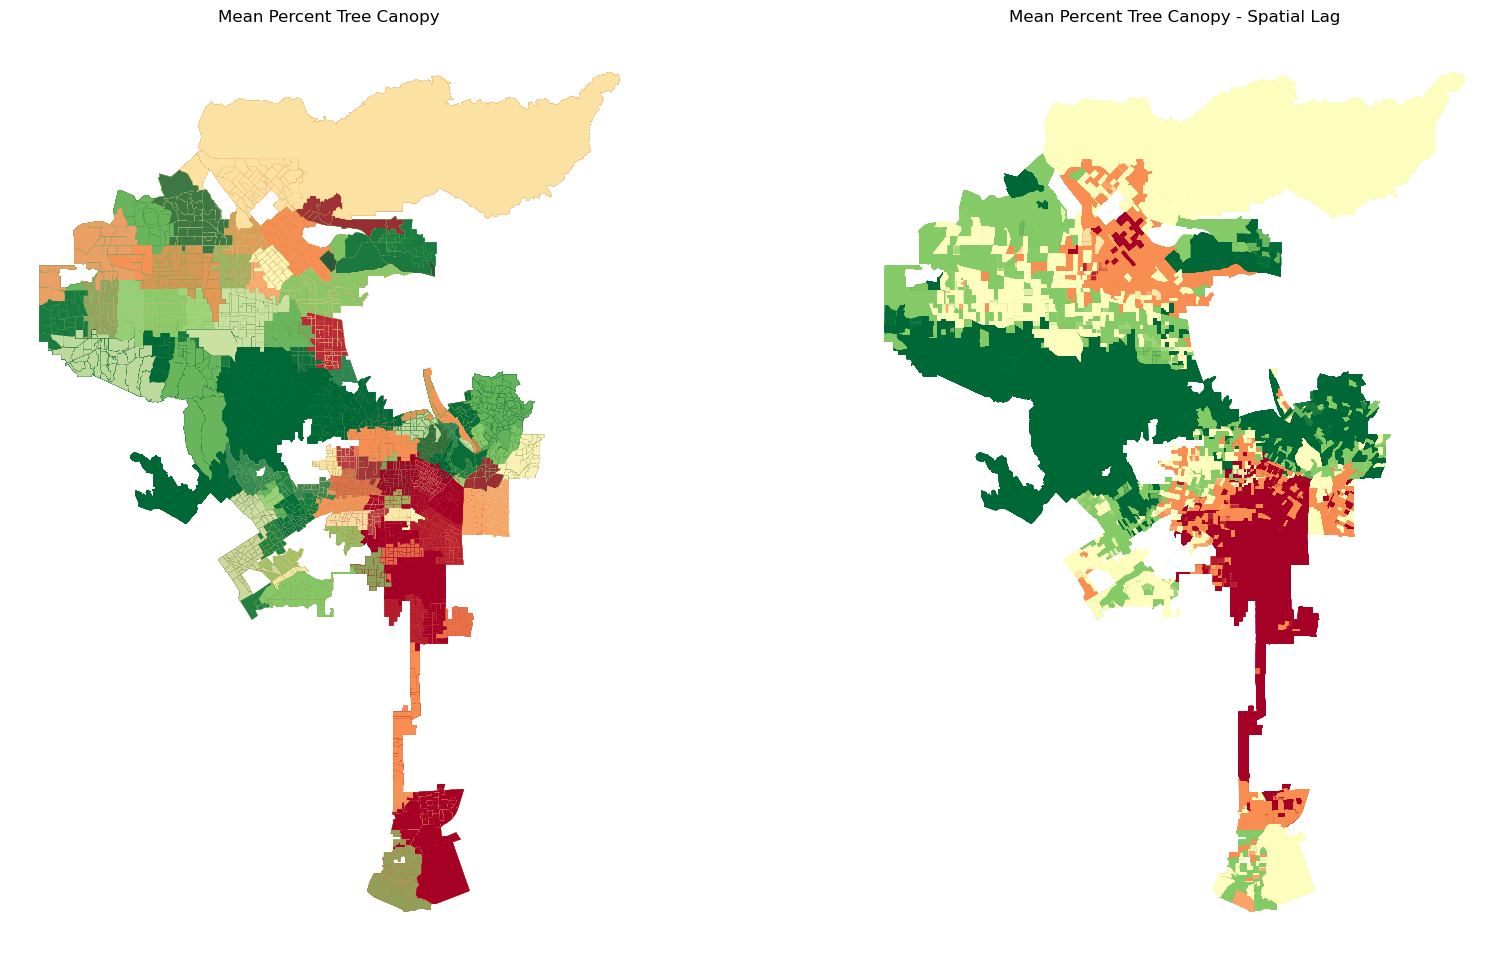

In [42]:
# creating side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))  


# pct tree canopy map on left
CHSAbd.plot(ax=ax[0], 
         column='MEAN_PCT_TreeCanopy', 
         cmap='RdYlGn', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Mean Percent Tree Canopy")

# spatial lag for pct tree canopy map on right
CHSAbd.plot(ax=ax[1],
         column='Mean Percent Tree Canopy_lag', 
         cmap='RdYlGn', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Mean Percent Tree Canopy - Spatial Lag")

plt.show()

In [35]:
# calculating moran's I value for pct tree canopy
y = CHSAbd.MEAN_PCT_TreeCanopy
moran1 = Moran(y, wq)  
moran1.I

0.4794804362990465

Calculating Moran's I value for the percent tree canopy cover, we see that there is a positive spatial autocorrelation, indicating that areas of high percent tree canopy cover tend to cluster together. The same can be said for areas of low percent tree canopy cover.     

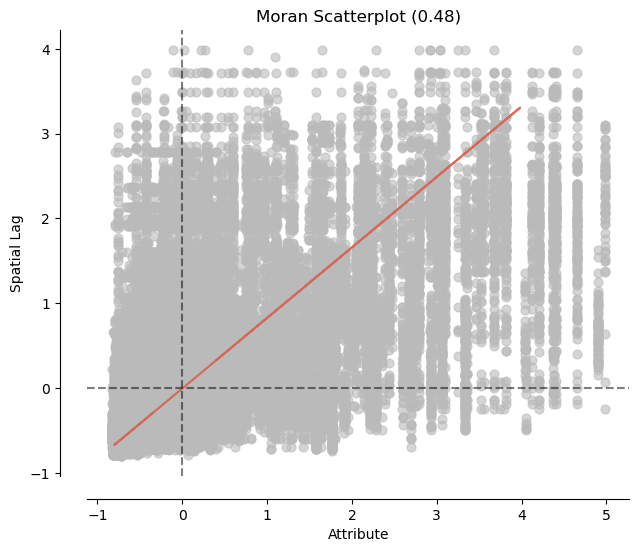

In [44]:
# creating scatterplot of result 
fig, ax = moran_scatterplot(moran1, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>)

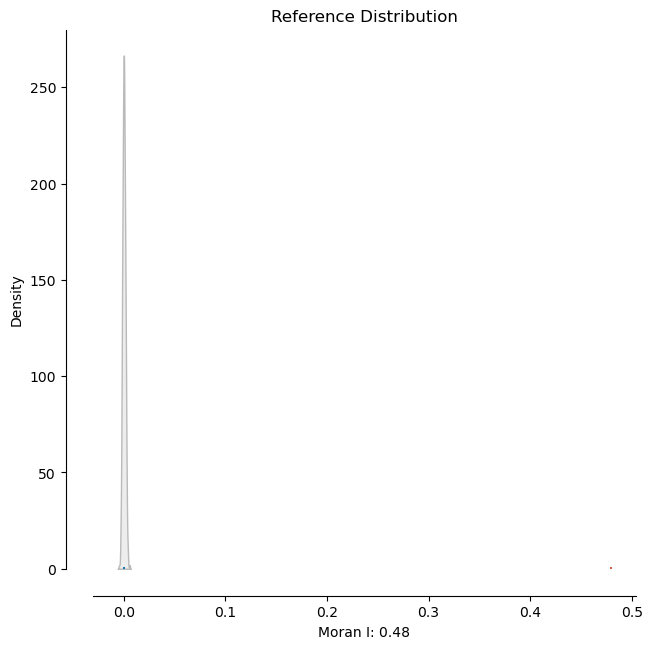

In [45]:
# comparing observed Moran’s I value to reference distribution
plot_moran_simulation(moran1,aspect_equal=False) # gives normal dist versus the actual value -- to right saying there is clustering 

In [46]:
# computing p-value for Moran's I 1 
moran1.p_sim # 99% confidence -- observed datapoint and surrounding spatial lag how likely is it that they would be very similar -- so can say with 99% confidence there is spatial clustering by block group in the city of LA 

0.001

By comparing our Moran I value with a sampling distribution, we see that our observed value falls outside of the distribution of Moran’s I values under the null hypothesis that canopy cover is randomly distributed. In turn, by computing the p-value for Moran's I value, we find that we can reject our null hypothesis. We can say with 99% confidence there is spatial clustering by neighborhood in the city of LA in regards to tree canopy cover. 

### Local Spatial Autocorrelation – Percent Tree Canopy

Next, we can identify where clusters are located by employing Local Indicators of Spatial Association (LISA). LISA will enable us to identify areas with high values of canopy cover near other high values of tree canopy cover(HH), low values with nearby low values (LL), low values with high values in its neighborhood, and vice-versa.

In [36]:
# calculating local moran values -- classifying in specific groups 
lisa = esda.moran.Moran_Local(y, wq) 

In [ ]:
# Plotting result
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)  
ax.set_xlabel("Mean Percent Tree Canopy")
ax.set_ylabel('Spatial Lag of Mean Percent Tree Canopy')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()
#points are all block groups and can see clusters -- clustering above .47 value  

A scatterplot of our Lisa clustering enables us to observe the distribution of neighborhoods that have a p-value less than 0.05 in each quadrant. Here we see the statistically significant, spatially autocorrelated geographies for each set of HH, LL, LH, and HL. We can visualize this to identify the geographic location of these neighborhoods in LA County.

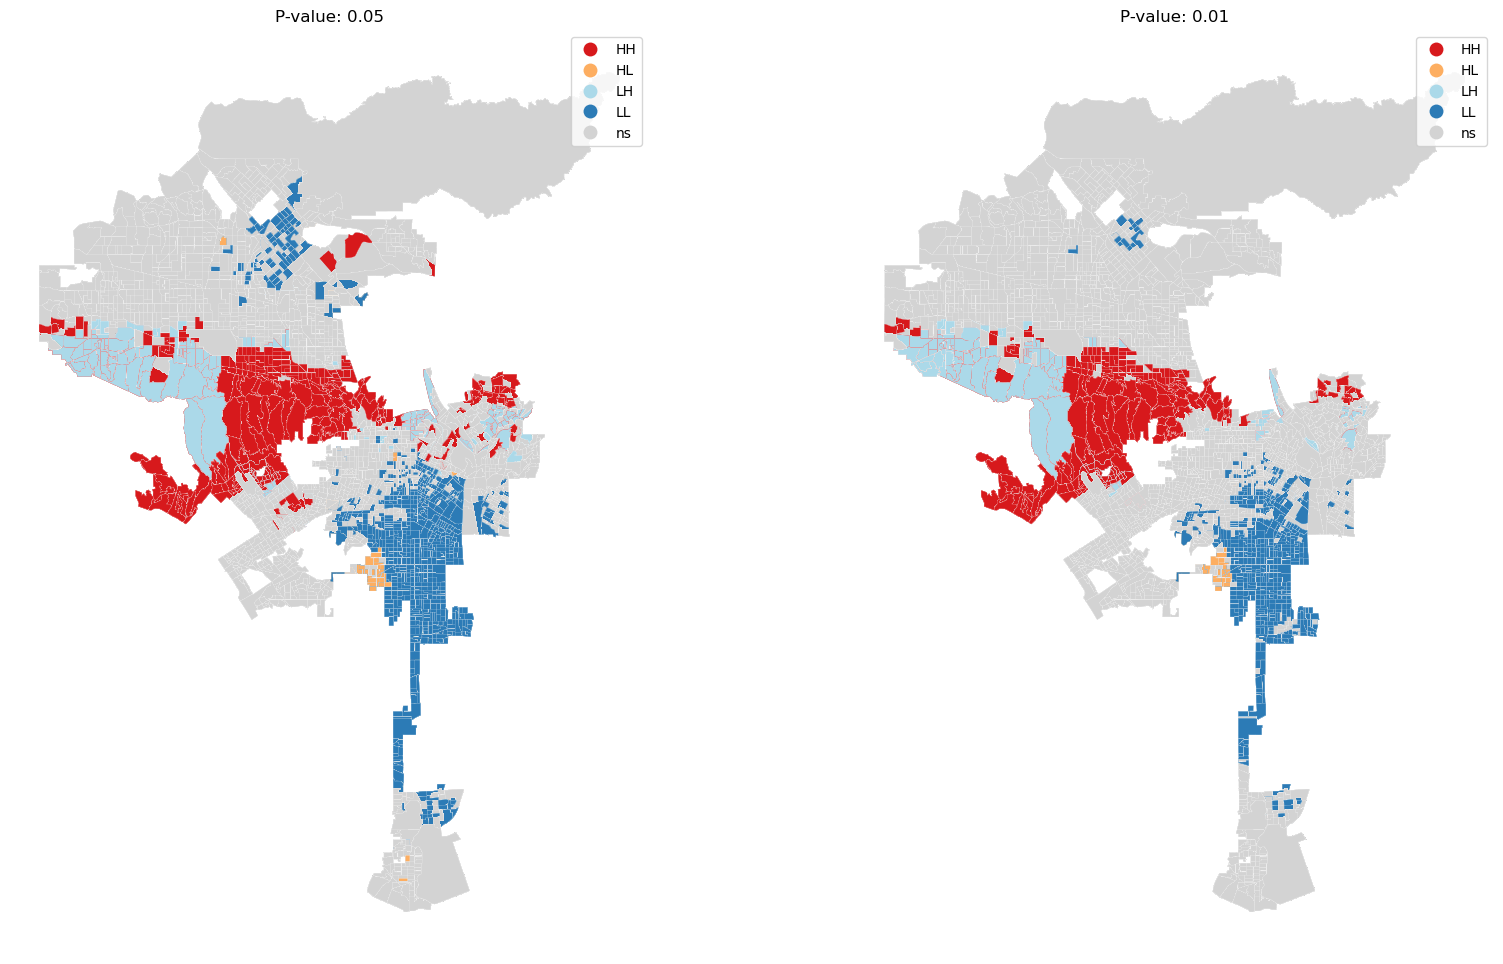

In [37]:
# create side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# count map on left for lisa clustering
lisa_cluster(lisa, CHSAbd, p=0.05, ax=ax[0]) #95% confidence 

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on right for lisa clustering
lisa_cluster(lisa, CHSAbd, p=0.01, ax=ax[1]) #99% confidence 
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()
fig.savefig('canopylisa.png')

These subplots allow us to see the heavy clustering of neighborhoods with high tree canopy cover in the northwest of LA County near Bel Air and Brentwood at both a 95% and 99% confidence level. Likewise, we see a significant clustering of low tree canopy cover (LL) in parts of Central and South LA around the Westlake neighborhood. However, we see a lack of statistically significant clustering of tree canopy cover in most of the block groups within the Silverlake neighborhood. From a broader perspective, with our calculation of Moran's I for global spatial autocorrelation and our local spatial autocorrelation, we can say with 99% confidence that there is statistically significant (nonrandom) spatial clustering of high and low tree canopy cover in LA County. In turn, we will run the same spatial statistical analysis for percent transit use by census block.  

### Global Spatial Autocorrelation – Percent Transit Use

Using global Moran's I statistic, we will again quantify the degree to which similar geographies are clustered but this time in regards to the percent transit use. 

In [24]:
# create a new column for the spatial lag of transit use-- avg of all neighbors defined by weight (8) 
CHSAbd['Percent Transit Users_lag'] = lps.weights.lag_spatial(wq, CHSAbd['Percent Transit Users'])

In [25]:
# creating a column calculating difference between pct transit users and lag 
CHSAbd['t_lag_diff'] = CHSAbd['Percent Transit Users'] - CHSAbd['Percent Transit Users_lag']

In [ ]:
# creating side-by-side subplots for second variable
fig, ax = plt.subplots(1, 2, figsize=(20, 12)) # two plots (1 row, 2 columns) 


# regular pct transit use map on left
CHSAbd.plot(ax=ax[0], 
         column='Percent Transit Users', 
         cmap='cividis_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Percent Transit Users")

# spatial lag for pct transit use map on right
CHSAbd.plot(ax=ax[1], 
         column='Percent Transit Users_lag', 
         cmap='cividis_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Percent Transit Users - Spatial Lag")

plt.show()

Visualizing the differences between the percent transit use and the corresponding spatial lag. The subplot maps reveal apparent clustering. Once again, however, we need to quantify the degree of spatial correlations, which we can accomplish via global autocorrelation.

In [26]:
# calculating moran's I value for pct transit use
y = CHSAbd['Percent Transit Users']
moran2 = Moran(y, wq) 
moran2.I

0.5642519750346283

Calculating Moran's I value for the percent transit use, we see that there is a positive spatial autocorrelation, indicating that areas of high percent transit use tend to cluster together as well as areas of low percent transit use.

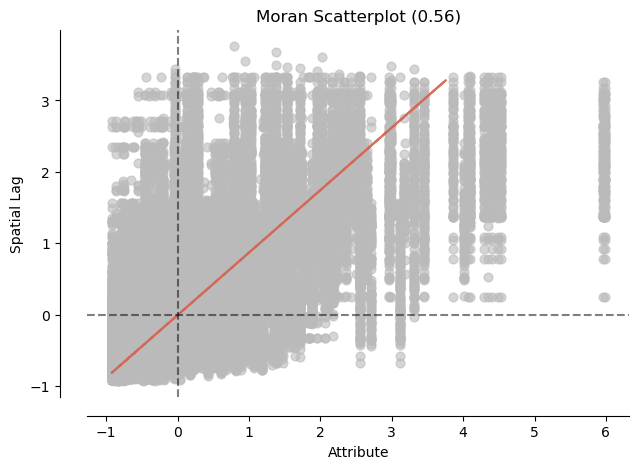

In [31]:
# creating scatterplot of result 2
fig, ax = moran_scatterplot(moran2, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.56', ylabel='Density'>)

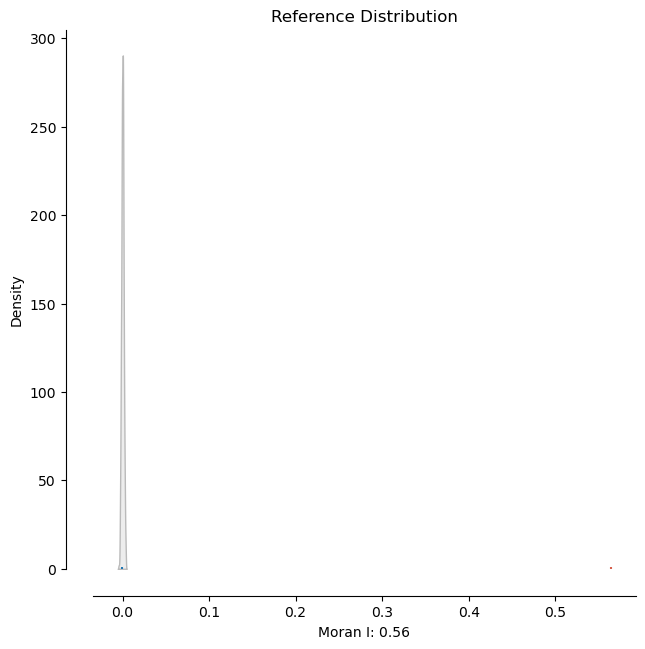

In [32]:
# comparing observed second Moran’s I value to reference distribution
plot_moran_simulation(moran2,aspect_equal=False) # gives normal dist versus the actual value -- to right saying there is clustering

In [33]:
# computing p-value for Moran's I 2
moran2.p_sim # 99% confidence -- observed datapoint and surrounding spatial lag how likely is it that they would be very similar -- so can say with 99% confidence there is spatial clustering by block group in the city of LA 

0.001

As with the percent tree canopy cover, by comparing our Moran I value with a sampling distribution, we see that our observed value falls outside of the distribution of Moran’s I value under the null hypothesis that percent transit use is randomly distributed. In turn, by computing the p-value for Moran's I value, we find that we can reject our null hypothesis. We can say with 99% confidence there is also spatial clustering by neighborhood in the city of LA in regards to the percent transit use.

### Local Spatial Autocorrelation – Percent Transit Use

Again, we can identify where clusters are located by employing Local Indicators of Spatial Association (LISA). 

In [27]:
# calculating local moran values -- classifying in specific groups 
lisa = esda.moran.Moran_Local(y, wq) 

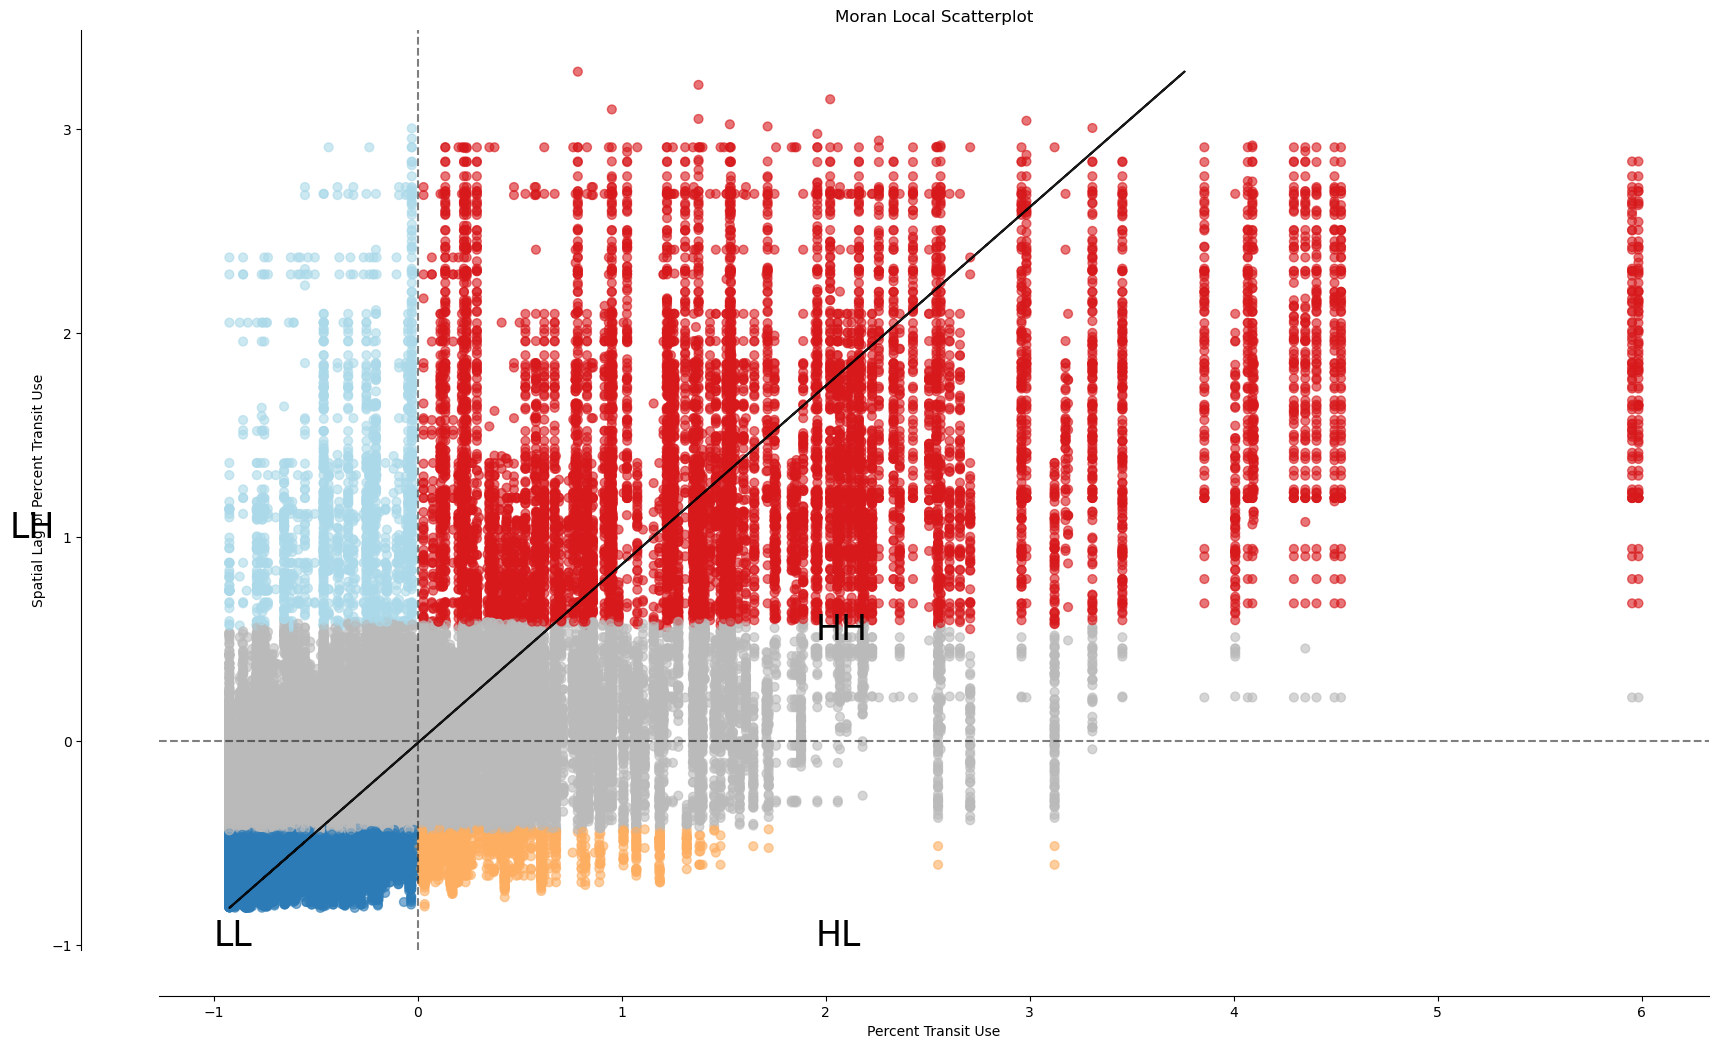

In [27]:
# Plotting lis clustering 
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)  
ax.set_xlabel("Percent Transit Use")
ax.set_ylabel('Spatial Lag of Percent Transit Use')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()
#points are all block groups and can see clusters -- clustering above .73 value

This scatterplot of our Lisa clustering enables us to observe the distribution of neighborhoods that have a p-value less than 0.05 in each quadrant. Here we see the statistically significant, spatially autocorrelated geographies for each set of HH, LL, LH, and HL. We can visualize this to identify the geographic location of these neighborhoods in LA County.

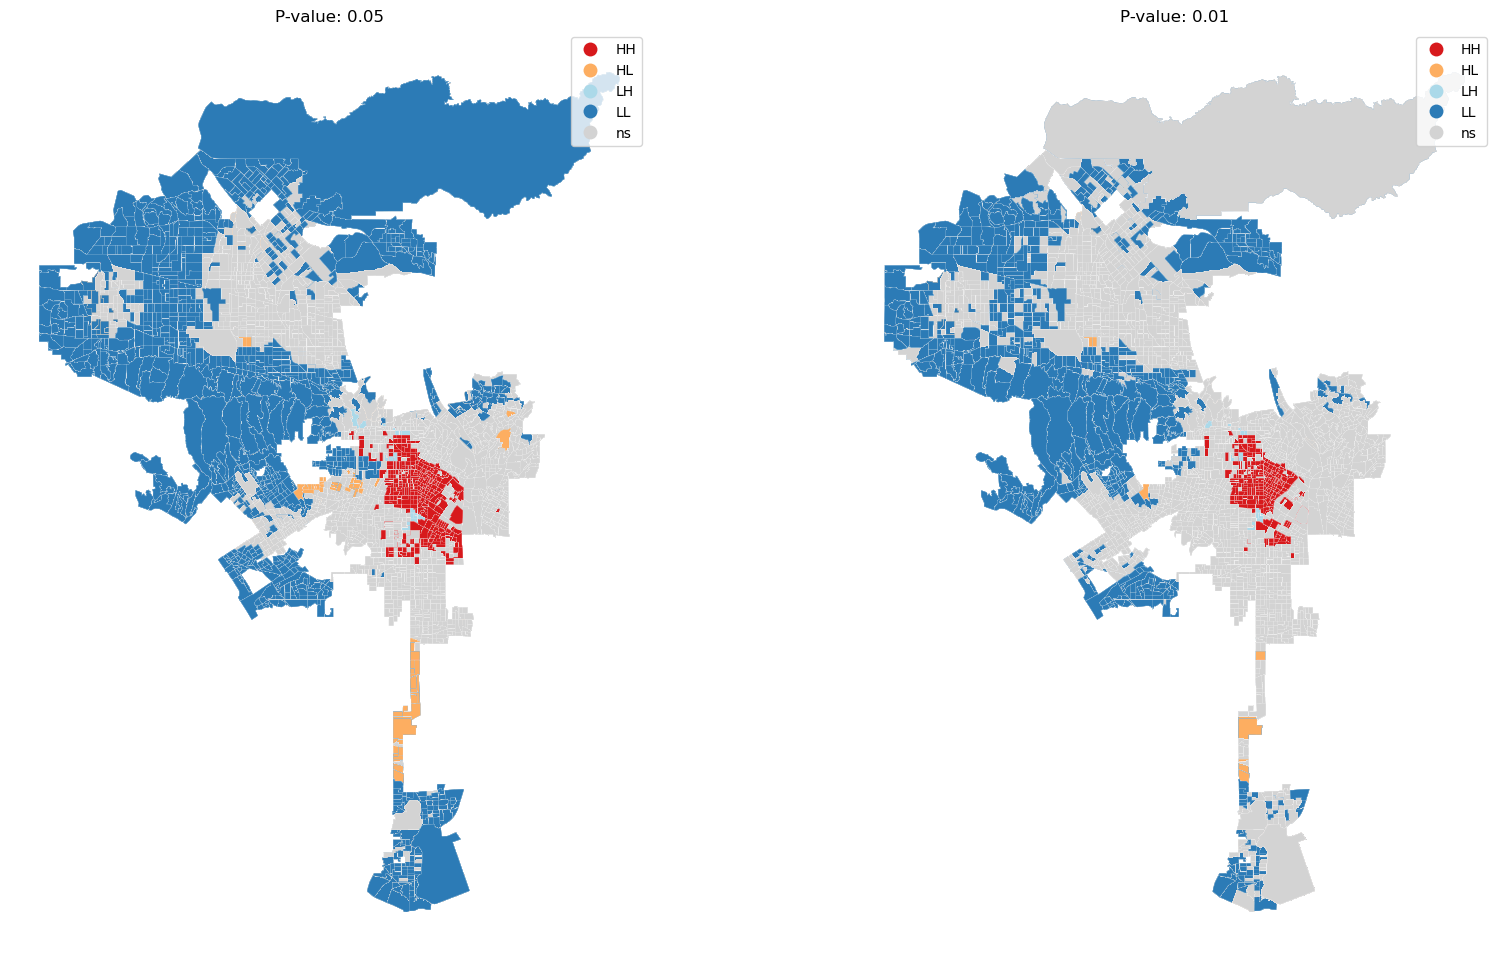

In [28]:
# create side-by-side subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# count map on left for lisa clustering 2
lisa_cluster(lisa, CHSAbd, p=0.05, ax=ax[0]) #95% confidence 

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on right for lisa clustering 2
lisa_cluster(lisa, CHSAbd, p=0.01, ax=ax[1]) #99% confidence 
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()
fig.savefig('transitlisa.png')

Akin to the spatial statistics for percent tree canopy cover, our subplots of LISA clustering reveal heavy clustering of neighborhoods with low transit use in the northwest of LA County at both a 95% and 99% confidence level. Additionally, we see a heavy clustering of high transit use (HH) in parts of Central and South LA, including block groups within the Westlake neighborhood. Again, we see a lack of statistically significant clustering of transit use in most of the block groups within the Silverlake neighborhood. Overall, with our calculation of Moran's I for global spatial autocorrelation and our local spatial autocorrelation, we can say with 99% confidence that there is statistically significant (nonrandom) spatial clustering of high and low percent transit use in LA County.

### Comparisons between Two Spatial Statistical Analyses 

When combined, our two sets of spatial statistics (for percent tree canopy cover and percent transit), reveal similarities in their statistically significant spatial clustering. While we are limited in the linkages we can make between these two sets of statistics, we can note that both variables share similar Moran's I values 0.48 and 0.56 for percent tree canopy cover and percent transit use respectively. Additionally, our visualizations of the LISA clustering reveal similar geographies for both variables with quadrants HH and LL indirectly related. 